In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os

2024-10-23 09:32:01.016580: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 09:32:01.020403: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 09:32:01.031636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 09:32:01.048222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 09:32:01.052972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 09:32:01.066992: I tensorflow/core/platform/cpu_feature_gu

Enter the initial velocity (m/s):  20
Enter the launch angle in degrees:  50
Enter the cross-sectional area (m^2):  1


/home/jupyter-yasai/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


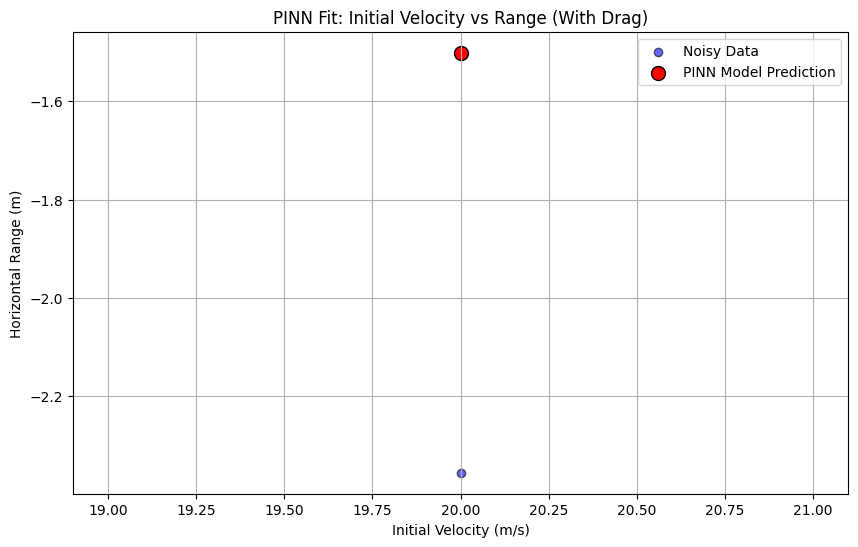

Data saved to pinn_simulation_results.csv


In [2]:


# Function to get user inputs
def get_user_inputs():
    velocity = float(input("Enter the initial velocity (m/s): "))  # User input for initial velocity
    angle = float(input("Enter the launch angle in degrees: "))  # User input for launch angle
    cross_section = float(input("Enter the cross-sectional area (m^2): "))  # User input for cross-sectional area
    return velocity, angle, cross_section

# Get user inputs
initial_velocity, angle_deg, A_input = get_user_inputs()

# Convert angle from degrees to radians
theta = tf.constant(np.radians(angle_deg), dtype=tf.float32)  # Launch angle in radians
initial_velocity = tf.constant(initial_velocity, dtype=tf.float32)  # Initial velocity
A = tf.constant(A_input, dtype=tf.float32)  # Cross-sectional area

# Fixed parameters
g = tf.constant(9.81, dtype=tf.float32)  # Gravity (m/s^2)
C_d = tf.constant(0.47, dtype=tf.float32)  # Drag coefficient for a sphere.
rho = tf.constant(1.225, dtype=tf.float32)  # Air density at sea level (kg/m^3).
m = tf.constant(0.1, dtype=tf.float32)  # Mass of the projectile (kg).

# Calculate the true range using the provided formula: d = (v^2 * sin(2 * theta)) / (g + (C_d * rho * A * v) / (2 * m))
drag_term = (C_d * rho * A * initial_velocity) / (2 * m)
true_range_with_drag = (initial_velocity**2 * np.sin(2 * theta)) / (g + drag_term)

# Add some light noise to the range value to simulate measurement variations.
noisy_range = true_range_with_drag + np.float32(np.random.normal(0, 5))  # Fixed by using np.float32()

# Prepare the input and output data for training the neural network
X_velocity = tf.convert_to_tensor([[initial_velocity.numpy()]], dtype=tf.float32)  # Input: Initial velocity as TensorFlow tensor
y_range_noisy = tf.convert_to_tensor([noisy_range], dtype=tf.float32)  # Output: Noisy range value as TensorFlow tensor

# Define a custom loss function that combines data loss and physics-based loss.
def pinn_loss(y_true, y_pred):
    # Ensure y_true and y_pred are in float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Extract the corresponding X value
    X_batch = X_velocity[:tf.shape(y_pred)[0]]  # Adjust to the current batch size

    # Calculate the drag term for the current batch
    drag_term_batch = (C_d * rho * A * X_batch) / (2 * m)
    
    # Physics formula for range with drag in the batch
    physics_based_range = (X_batch ** 2 * tf.sin(2 * theta)) / (g + drag_term_batch)
    
    # MSE for the data (difference between predictions and true values)
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Physics-based MSE: enforce the relationship from the motion equation with drag.
    physics_loss = tf.reduce_mean(
        tf.square(y_pred - physics_based_range)
    )
    
    # Combine losses with a weight for the physics loss.
    lambda_weight = 0.1  # You can adjust this to balance the two terms.
    total_loss = data_loss + lambda_weight * physics_loss
    return total_loss

# Define a Keras Sequential model.
pinn_model = Sequential([
    Dense(64, activation='relu', input_dim=1),  # Input layer with 64 neurons
    Dense(64, activation='relu'),               # Hidden layer with 64 neurons
    Dense(1)                                    # Output layer for predicting range
])

# Compile the model using the custom loss function.
pinn_model.compile(optimizer=Adam(learning_rate=0.01), loss=pinn_loss)

# Train the model on the velocity data and the noisy range for a small number of epochs.
history = pinn_model.fit(X_velocity, y_range_noisy, epochs=50, batch_size=1, verbose=0)

# Make predictions using the trained PINN model.
y_pred_pinn = pinn_model.predict(X_velocity).flatten()

# Plot the original data and the PINN model's predictions.
plt.figure(figsize=(10, 6))
plt.scatter(X_velocity.numpy(), y_range_noisy.numpy(), color='blue', alpha=0.6, edgecolors='black', label='Noisy Data')
plt.scatter(X_velocity.numpy(), y_pred_pinn, color='red', label='PINN Model Prediction', s=100, edgecolors='black')
plt.xlabel('Initial Velocity (m/s)')
plt.ylabel('Horizontal Range (m)')
plt.title('PINN Fit: Initial Velocity vs Range (With Drag)')
plt.grid(True)
plt.legend()
plt.show()

# Save results to a CSV file (appending if it exists)
csv_filename = 'pinn_simulation_results.csv'

# Prepare a dictionary with the data
data = {
    'initial_velocity': [initial_velocity.numpy()],
    'angle_deg': [angle_deg],
    'cross_sectional_area': [A.numpy()],
    'noisy_range': [y_range_noisy.numpy()[0]],
    'predicted_range': [y_pred_pinn[0]]
}

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Check if the file exists, and append or create accordingly
if os.path.exists(csv_filename):
    df.to_csv(csv_filename, mode='a', header=False, index=False)  # Append without writing the header
else:
    df.to_csv(csv_filename, mode='w', header=True, index=False)   # Create the file with headers

print(f"Data saved to {csv_filename}")
